In [26]:
# OPTIONAL: Load the "autoreload" eX_orig[alias]tension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
import pandas as pd
import seaborn as sns
from src.go_util import get_ensembl_mappings
from src.config import get_experiment_artifacts, get_hussmann_supplementary_xlsx, FILTER_COUNT, METHOD, PROFILE_TYPE

In [28]:
FILTER_COUNT, METHOD, PROFILE_TYPE

(700, 'robust_cov', 'paired-replicates')

In [29]:
# Get http://geneontology.org/ontology/go-basic.obo
from goatools.base import download_go_basic_obo
obo_fname = download_go_basic_obo(obo="artifacts/go-basic.obo")


# Get ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz
from goatools.base import download_ncbi_associations
fin_gene2go = download_ncbi_associations(gene2go="artifacts/gene2go")

  EXISTS: artifacts/go-basic.obo
  EXISTS: artifacts/gene2go


In [30]:
from goatools.obo_parser import GODag

obodag = GODag("artifacts/go-basic.obo")

artifacts/go-basic.obo: fmt(1.2) rel(2023-01-01) 46,739 Terms


In [31]:
from __future__ import print_function
from goatools.anno.genetogo_reader import Gene2GoReader

# Read NCBI's gene2go. Store annotations in a list of namedtuples
objanno = Gene2GoReader(fin_gene2go, taxids=[10090])

# Get namespace2association where:
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene
ns2assoc = objanno.get_ns2assc()

for nspc, id2gos in ns2assoc.items():
    print("{NS} {N:,} annotated mouse genes".format(NS=nspc, N=len(id2gos)))

HMS:0:00:05.280781 429,754 annotations, 29,773 genes, 19,208 GOs, 1 taxids READ: artifacts/gene2go 
MF 17,372 annotated mouse genes
CC 19,353 annotated mouse genes
BP 18,599 annotated mouse genes


In [32]:
all_genes = pd.read_pickle(get_experiment_artifacts() + "augmented_outlier_results.pkl").index.to_list()
all_genes[:5]

['0610009B22Rik',
 '0610010K14Rik',
 '0610030E20Rik',
 '0610040J01Rik',
 '1110004F10Rik']

In [51]:
mappings = get_ensembl_mappings()
geneid2symbol = {}
for g in all_genes:
    if g in mappings:
        try:
            geneid2symbol[int(mappings[g]['entrezgene_id'])] = g
        except:
            continue

background_gene_ids = []
for g in all_genes:
    if g in mappings:
        try:
            background_gene_ids.append(int(mappings[g]['entrezgene_id']))
        except:
            continue

len(background_gene_ids)

18027

In [52]:
background_gene_ids[:5]

[66050, 104457, 68364, 76261, 56372]

In [53]:
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

goeaobj = GOEnrichmentStudyNS(
        background_gene_ids, # List of mouse genes
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method


Load BP Ontology Enrichment Analysis ...
 86% 15,481 of 18,027 population items found in association

Load CC Ontology Enrichment Analysis ...
 91% 16,359 of 18,027 population items found in association

Load MF Ontology Enrichment Analysis ...
 82% 14,849 of 18,027 population items found in association


In [54]:
adamson_data = pd.read_excel(get_hussmann_supplementary_xlsx(4), sheet_name="Table S4", skiprows=1)
outliers = adamson_data["Gene"].str.capitalize()

In [55]:
# [outliers]
geneids_study = []
for g in outliers:
    if g in mappings:
        try:
            geneids_study.append(int(mappings[g]['entrezgene_id']))
        except:
            continue

len(geneids_study)

448

In [56]:
goea_results_all = goeaobj.run_study(geneids_study)
goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]


Runing BP Ontology Analysis: current study set of 448 IDs.
 99%    423 of    428 study items found in association
 96%    428 of    448 study items found in population(18027)
Calculating 12,633 uncorrected p-values using fisher_scipy_stats
  12,633 terms are associated with 15,480 of 18,027 population items
   1,669 terms are associated with    423 of    448 study items
  METHOD fdr_bh:
     318 GO terms found significant (< 0.05=alpha) (311 enriched +   7 purified): statsmodels fdr_bh
     413 study items associated with significant GO IDs (enriched)
       6 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 448 IDs.
 99%    425 of    428 study items found in association
 96%    428 of    448 study items found in population(18027)
Calculating 1,787 uncorrected p-values using fisher_scipy_stats
   1,787 terms are associated with 16,358 of 18,027 population items
     355 terms are associated with    425 of    448 study items
 

In [57]:
print('{N} of {M:,} results were significant'.format(
    N=len(goea_results_sig),
    M=len(goea_results_all)))

657 of 18,966 results were significant


In [58]:
print('Significant results: {E} enriched, {P} purified'.format(
    E=sum(1 for r in goea_results_sig if r.enrichment=='e'),
    P=sum(1 for r in goea_results_sig if r.enrichment=='p')))

Significant results: 622 enriched, 35 purified


In [59]:
ctr = cx.Counter([r.NS for r in goea_results_sig])
print('Significant results[{TOTAL}] = {BP} BP + {MF} MF + {CC} CC'.format(
    TOTAL=len(goea_results_sig),
    BP=ctr['BP'],  # biological_process
    MF=ctr['MF'],  # molecular_function
    CC=ctr['CC'])) # cellular_component

Significant results[657] = 318 BP + 179 MF + 160 CC


In [60]:
goeaobj.wr_xlsx("artifacts/adamson_GO_terms.xlsx", goea_results_sig)

    657 items WROTE: artifacts/adamson_GO_terms.xlsx


In [61]:
df = pd.read_excel("artifacts/adamson_GO_terms.xlsx".format(get_experiment_artifacts()))
df.head()


,GO,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_fdr_bh,study_items
0,GO:0006281,BP,e,DNA repair,217/428,361/18027,1.284128e-278,7,217,1.622239e-274,"11545, 11546, 11792, 11920, 12013, 12021, 1214..."
1,GO:0006974,BP,e,cellular response to DNA damage stimulus,214/428,487/18027,5.175828e-234,4,214,3.269312e-230,"11545, 11546, 11792, 11920, 12021, 12144, 1218..."
2,GO:0006338,BP,e,chromatin remodeling,71/428,162/18027,1.968009e-72,5,71,8.287286e-69,"12054, 12055, 13990, 14055, 14056, 14534, 1518..."
3,GO:0006310,BP,e,DNA recombination,54/428,78/18027,3.010787e-70,7,54,9.508818e-67,"11792, 12144, 12189, 12190, 13870, 14375, 1688..."
4,GO:0000724,BP,e,double-strand break repair via homologous reco...,53/428,87/18027,2.474957e-64,9,53,6.253225e-61,"11920, 12144, 12189, 12190, 13404, 13831, 1557..."


In [62]:
df_out = df[["name", "NS", "study_items"]]
df_out = df_out[df_out["NS"] == "MF"]
dummy_MF_df = pd.Series(dict(zip(df_out["name"], df_out["study_items"].str.replace(" ", "").str.split(",")))).str.join('|').str.get_dummies()
print(dummy_MF_df.shape)
dummy_MF_df.iloc[:5, :5]

(179, 396)


,100040608,100683,100710,101739,104248
DNA binding,0,0,1,1,0
damaged DNA binding,0,0,0,0,0
chromatin binding,0,0,0,1,0
helicase activity,0,0,0,0,0
single-stranded DNA binding,0,0,0,0,0


In [70]:
repair_genes = []
for geneid in dummy_MF_df.columns:
    if int(geneid) in geneid2symbol:
        repair_genes.append(geneid2symbol[int(geneid)])
len(repair_genes)

dummy_MF_df.columns = repair_genes
dummy_MF_df.head()

,Fancf,Trrap,Pds5b,Psip1,Cabin1,Ddx1,Fancm,Tdp1,Brd9,Espl1,...,Recql4,Polh,Rad54l2,Kat5,Smarcd2,Smarcd1,Arid1a,Smarca5,Ube2n,Nat10
DNA binding,0,0,1,1,0,1,1,0,0,0,...,0,1,1,0,0,0,1,1,0,0
damaged DNA binding,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
chromatin binding,0,0,0,1,0,1,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
helicase activity,0,0,0,0,0,1,1,0,0,0,...,1,0,1,0,0,0,0,1,0,0
single-stranded DNA binding,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
print(dummy_MF_df.sum(axis=1).sort_values(ascending=False).head(10))

DNA binding             209
protein binding         200
metal ion binding       151
hydrolase activity      113
nucleotide binding      111
ATP binding             109
chromatin binding        97
transferase activity     85
nucleic acid binding     51
RNA binding              51
dtype: int64


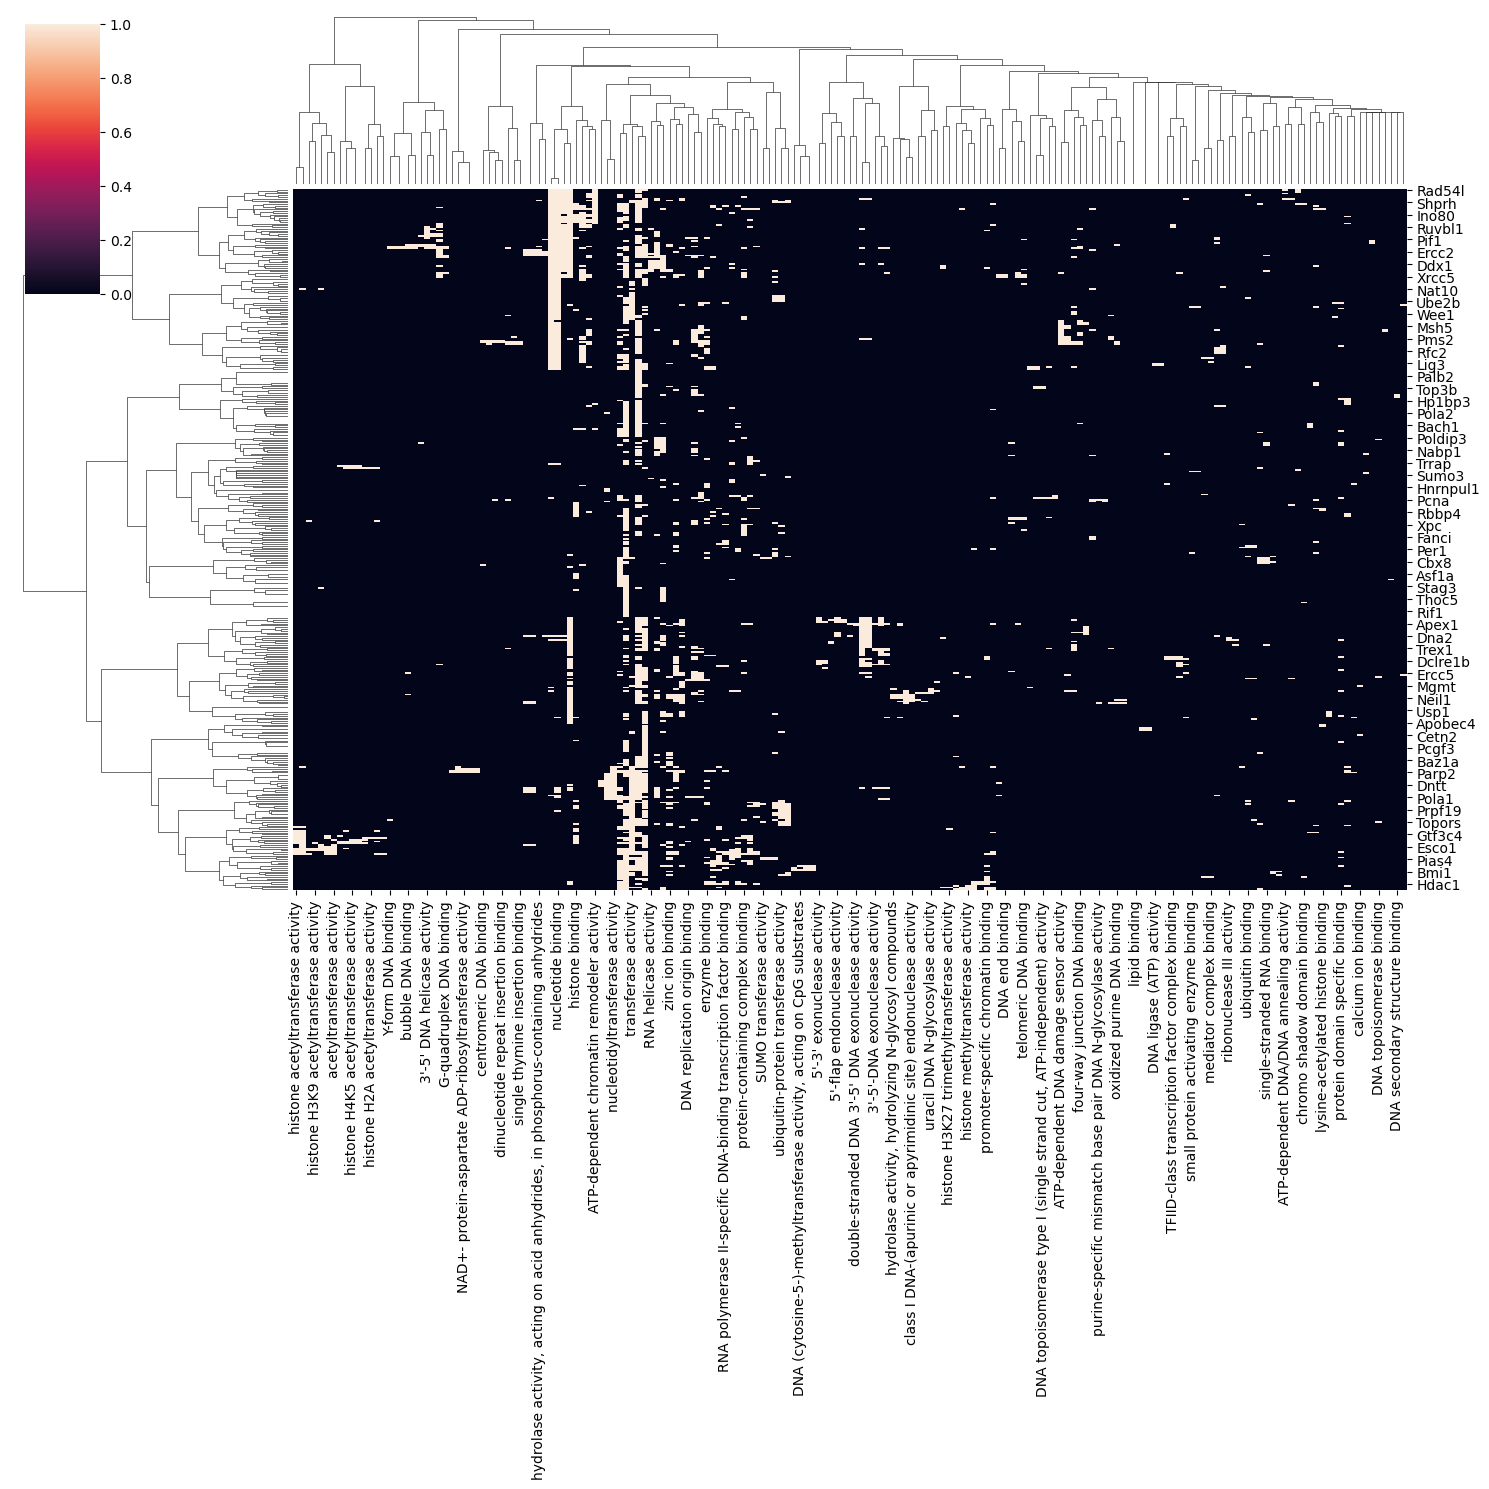

In [74]:
sns.clustermap(dummy_MF_df.T, figsize=(15, 15), method="ward", metric="jaccard")

In [84]:
dummy_MF_df.to_pickle("artifacts/adamson_MF_terms.pkl")

In [80]:
df_out = df[["name", "NS", "study_items"]]
df_out = df_out[df_out["NS"] == "BP"]
dummy_BP_df = pd.Series(dict(zip(df_out["name"], df_out["study_items"].str.replace(" ", "").str.split(",")))).str.join('|').str.get_dummies()
print(dummy_BP_df.shape)

repair_genes = []
for geneid in dummy_BP_df.columns:
    if int(geneid) in geneid2symbol:
        repair_genes.append(geneid2symbol[int(geneid)])
len(repair_genes)

dummy_BP_df.columns = repair_genes

dummy_BP_df.iloc[:5, :5]



(318, 415)


,Fancf,Trrap,Pds5b,Psip1,Cabin1
DNA repair,1,0,1,0,0
cellular response to DNA damage stimulus,1,0,0,0,0
chromatin remodeling,0,0,0,0,0
DNA recombination,0,0,0,0,0
double-strand break repair via homologous recombination,0,0,0,0,0


In [78]:
print(dummy_BP_df.sum(axis=1).sort_values(ascending=False).head(10))

DNA repair                                                   217
cellular response to DNA damage stimulus                     214
chromatin organization                                        80
cell cycle                                                    74
positive regulation of DNA-templated transcription            72
chromatin remodeling                                          71
negative regulation of transcription by RNA polymerase II     61
regulation of transcription by RNA polymerase II              56
positive regulation of transcription by RNA polymerase II     56
DNA recombination                                             54
dtype: int64


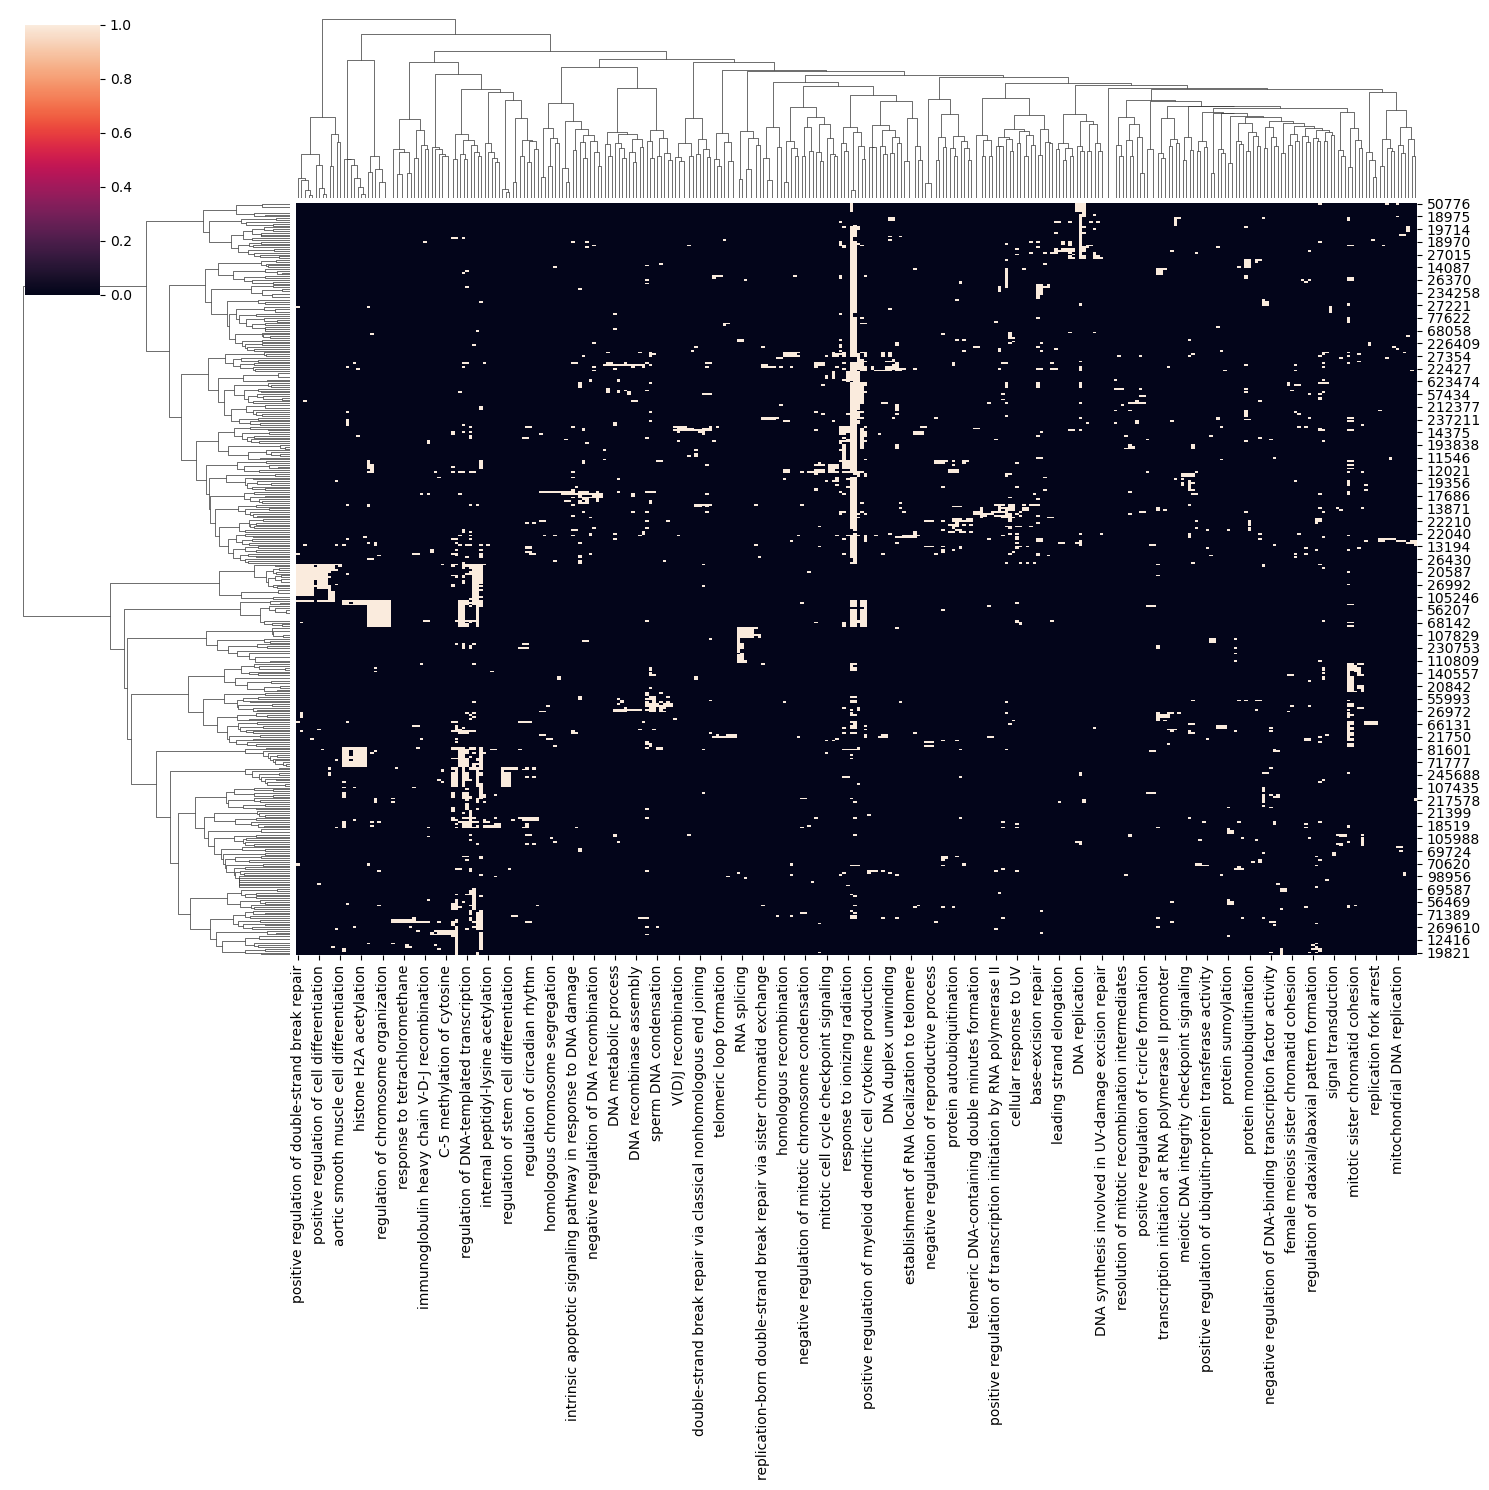

In [79]:
sns.clustermap(dummy_BP_df.T, figsize=(15, 15), method="ward", metric="jaccard")

In [82]:
print(dummy_BP_df.sum(axis=1).sort_values(ascending=False).head(20))

DNA repair                                                   217
cellular response to DNA damage stimulus                     214
chromatin organization                                        80
cell cycle                                                    74
positive regulation of DNA-templated transcription            72
chromatin remodeling                                          71
negative regulation of transcription by RNA polymerase II     61
regulation of transcription by RNA polymerase II              56
positive regulation of transcription by RNA polymerase II     56
DNA recombination                                             54
double-strand break repair via homologous recombination       53
DNA replication                                               50
regulation of DNA-templated transcription                     49
negative regulation of DNA-templated transcription            46
telomere maintenance                                          44
double-strand break repai

In [83]:
dummy_BP_df.to_pickle("artifacts/adamson_BP_terms.pkl")